In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.optimize import curve_fit

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [2]:
def import_img(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

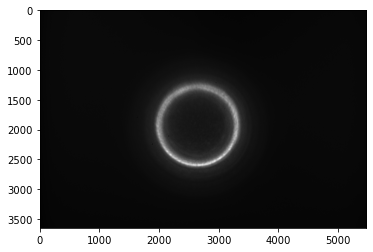

In [3]:
# Imports image to be processed
image = cv2.imread('sample0(10).bmp', cv2.IMREAD_GRAYSCALE)
processedimg = cv2.convertScaleAbs(image, alpha=3, beta=0)
output = image.copy()

plt.imshow(processedimg, cmap='gray')

In [4]:
def circlefinder(min, plot=True):
    # Binarizes Image
    img = cv2.threshold(image, min, 189, cv2.THRESH_BINARY)[1]
    # Detects the contours on the binary image using cv2.CHAIN_APPROX_NONE and extracts the outer and inner contours of annulus
    cnts, hier = cv2.findContours(image=img.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    cnts = sorted(cnts, key=len)
    outer = cnts[-1] # outer diameter contour
    inner = cnts[-2] # inner diameter contour

    # Initialize variables
    cx = list()
    cy = list()
    radii = list()
    # Finds center of mass and inner and outer circle radii
    for i in [inner, outer]:
        M = cv2.moments(i)

        cx.append(int(M['m10']/M['m00']))
        cy.append(int(M['m01']/M['m00']))
    
        area = cv2.contourArea(i)
        rad = int((area/np.pi)**(1/2))
        radii.append(rad)

    cx = sum(cx)/2
    cy = sum(cy)/2
    if plot==True:
        # Plots image and overlays the inner and outer circles of the annulus
        plt.figure(figsize=(15,15))
        ax = plt.gca()
        for rad in radii:
            circle = plt.Circle((cx, cy), rad, fill=False, color='red')
            ax.add_artist(circle)

        ax.imshow(output, cmap='gray')
    else:
        pass
    # Function outputs center of mass coordinates and radii
    return cx, cy, radii

w = interactive(circlefinder, min=(1,254,1)) # Interactive slider to change minimum intensity threshold 
display(w)

interactive(children=(IntSlider(value=127, description='min', max=254, min=1), Checkbox(value=True, descriptio…

In [5]:
img = cv2.threshold(image, 24, 189, cv2.THRESH_BINARY)[1]
# Detects the contours on the binary image using cv2.CHAIN_APPROX_NONE and extracts the outer and inner contours of annulus
cnts, hier = cv2.findContours(image=img.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
cnts = sorted(cnts, key=len)
outer = cnts[-1] # outer diameter
inner = cnts[-2] # inner diameter

# Initialize empty list
lst_intensities = list()

# For each list of contour points...
#for i in range(2):
    # Create a mask image that contains the contour filled in
cimg = np.zeros_like(image)
cv2.drawContours(cimg, [outer, inner], -1, color=255, thickness=-1)

    # Access the image pixels and create a 1D numpy array then add to list
pts = np.where(cimg == 255)
lst_intensities.append(image[pts[0], pts[1]])

In [6]:
# Binarizes Image
img = cv2.threshold(image, 24, 180, cv2.THRESH_BINARY)[1]
# Detects the contours on the binary image using cv2.CHAIN_APPROX_NONE and extracts the outer and inner contours of annulus
cnts, hier = cv2.findContours(image=img.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
cnts = sorted(cnts, key=len)
outer = cnts[-1] # outer diameter contour
inner = cnts[-2] # inner diameter contour

# Initialize variables
cx = list()
cy = list()
radii = list()
# Finds center of mass and inner and outer circle radii
for i in [inner, outer]:
    M = cv2.moments(i)

    cx.append(int(M['m10']/M['m00']))
    cy.append(int(M['m01']/M['m00']))
    
    area = cv2.contourArea(i)
    rad = int((area/np.pi)**(1/2))
    radii.append(rad)

cx = np.around(sum(cx)/2)
cy = np.around(sum(cy)/2)

In [7]:
np.shape(lst_intensities[0])

(586372,)

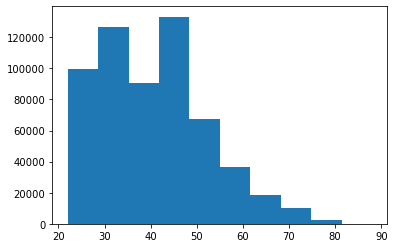

In [8]:
plt.hist(lst_intensities[0]);

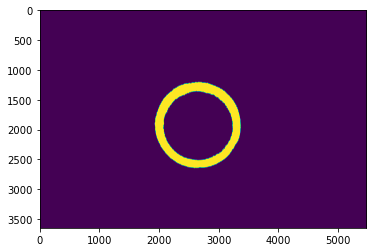

In [9]:
plt.imshow(cimg)

2643.0 1930.0 [575, 718]


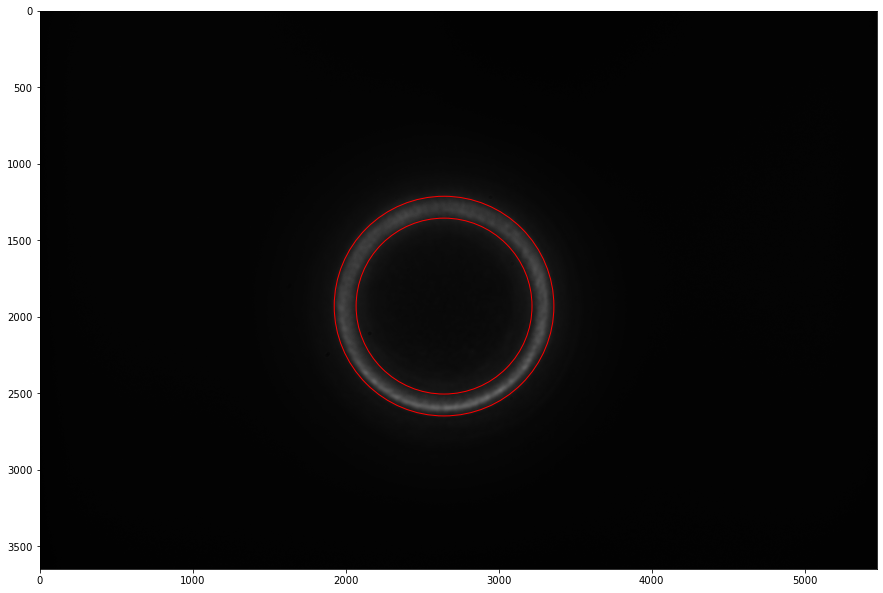

In [10]:
cx, cy, radii = circlefinder(24)
print(cx, cy, radii)

In [12]:
rngmin = int(cx-radii[1]*1.25)
rngmax = int(cx+radii[1]*1.25)

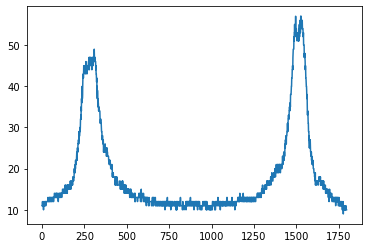

In [13]:
xval = np.linspace(1, len(img[0, rngmin:rngmax]), len(img[0, rngmin:rngmax]))

plt.plot(xval, image[int(len(img[:, 0])-cy), rngmin:rngmax])

In [23]:
data = image[int(len(img[:, 0])-cy), int(cx*1.12):rngmax]

In [24]:
xdata = np.linspace(1, len(img[0, int(cx*1.12):rngmax]), len(img[0, int(cx*1.12):rngmax]))

In [62]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


def lorentzian(x, *p):
    a, x0 , gam = p
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def asym_gauss (x, *p):
    """ Asymmetric Gaussian function with variable continuum level .
    Input :
    x - x- values ( radii )
    *p - parameters [ Amplitude , mean value , standard deviation ,
    constant left , constant right ]
    Output :
    f - y- values , fitted values of assymmetric Gaussian """
    A, mu , sigma , Kl , Kr = p
    f = np.zeros(len(x)) # initializing the array with the result
    cut = np.argmax(x > mu) # find x corresponding to the mean value
    f[0:cut]=(A-Kl)*np.exp(-(x[0:cut]-mu)**2/(2.*sigma**2)) + Kl
    f[cut:] = (A-Kr)*np.exp(-(x[cut:]-mu)**2/(2.*sigma**2)) + Kr

    return f

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
#p0 = [50., 50., 10.]

#coeff, var_matrix = curve_fit(gauss, xdata, data, p0=p0)

Fitted mean =  41.11787522790485
Fitted standard deviation =  289.80830100759107


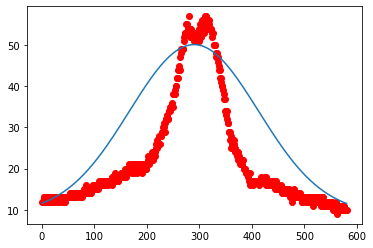

In [27]:
# Get the fitted curve
fit = gauss(xdata, *coeff)+min(data)

plt.scatter(xdata, data, label='Test data', color='red')
plt.plot(xdata, fit, label='Fitted data')

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print('Fitted mean = ', coeff[0])
print('Fitted standard deviation = ', coeff[1])

plt.show()

In [28]:
fwhm = 2*np.sqrt(2*np.log(2))*coeff[2]
fwhm/2

144.7545349000555

In [29]:
np.shape(image)

(3648, 5472)

In [134]:
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int64)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

def cross_slice(imgdata, padding=200):
    cx, cy, radii = imgdata
    size = np.shape(image)
    inner = radii[0]
    outer = radii[1]
    rngmin = int(cx-outer-padding)
    rngmax = int(cx+outer+padding)


    
    data = radial_profile(image, (cx, cy))
    
    datalength = len(data)
    xdata = np.linspace(1, datalength, datalength)

    p0 = [max(data), np.argmax(data), 50., 70, 50]

    coeff, var_matrix = curve_fit(asym_gauss, xdata, data, p0=p0)
    fitdata = asym_gauss(xdata, *coeff)

    mean = coeff[1]
    fwhm = 2*np.sqrt(2*np.log(2))*coeff[2]
    half_width = fwhm/2

    inner_rad = mean-half_width
    outer_rad = mean+half_width

    fig, ax = plt.subplots(1, 2, figsize=(30,12), tight_layout=True)

    midcircle = plt.Circle((cx, cy), mean, fill=False, color='red', linestyle='dashed')
    innercircle = plt.Circle((cx, cy), inner_rad, fill=False, color='green')
    outercircle = plt.Circle((cx, cy), outer_rad, fill=False, color='green')
    ax[0].add_artist(midcircle)
    ax[0].add_artist(innercircle)
    ax[0].add_artist(outercircle)

    ax[0].imshow(output, cmap='gray')

    ax[1].plot(data, label='Original Data', color='green')
    ax[1].plot(fitdata, label='Fitted Data', linestyle='--', color='red')
    
    ax[1].legend()

    return xdata, data

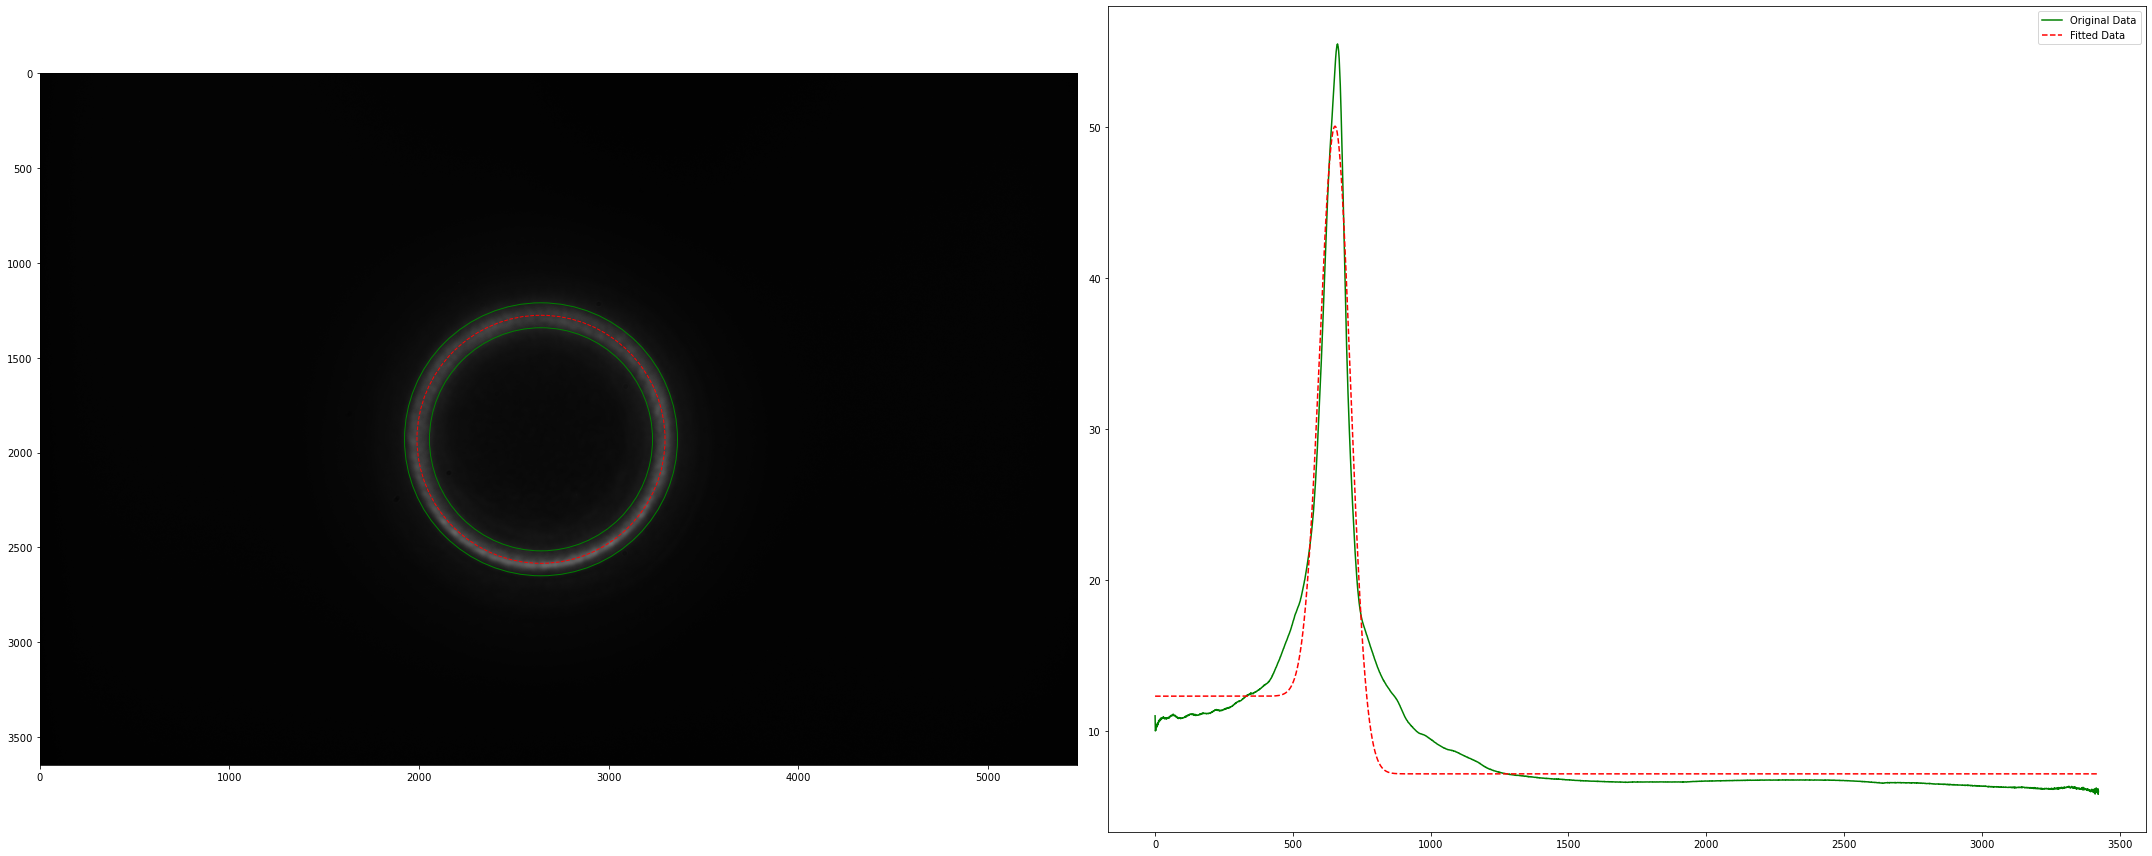

In [135]:
data_axis, data = cross_slice(circlefinder(24, plot=False))

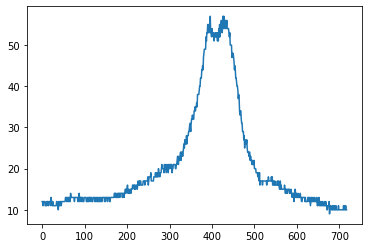

In [295]:
plt.plot(data)

In [291]:
len(img[:, 0])

3648

In [292]:
np.shape(img)

(3648, 5472)

In [35]:
import numpy as np

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int64)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

In [103]:
radial = radial_profile(image, (cx,cy))
radial

array([11.        , 10.        , 10.0625    , ...,  6.16666667,
        5.8       ,  6.        ])

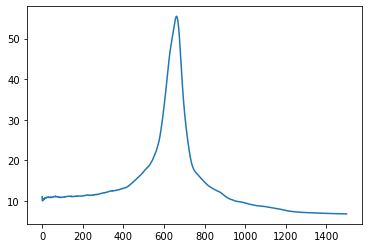

In [104]:
plt.plot(radial[:1500])

In [105]:
xrange = np.linspace(1, len(radial), len(radial))

Fitted mean =  653.9739538745145
Fitted standard deviation =  55.82111269646422


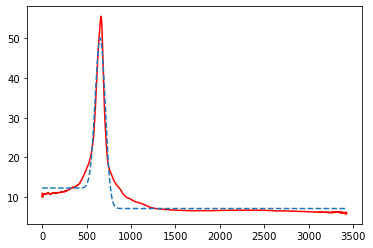

In [107]:
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [50., 500., 70., 50, 50]

coeff, var_matrix = curve_fit(asym_gauss, xrange, radial, p0=p0)

# Get the fitted curve
fit = asym_gauss(xrange, *coeff)

plt.plot(xrange, radial, label='Test data', color='red')
plt.plot(xrange, fit, label='Fitted data', linestyle='dashed')

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print('Fitted mean = ', coeff[1])
print('Fitted standard deviation = ', coeff[2])

plt.show()

array([639.59439254,  30.44702611, 280.90293239])